# Credit card fraud detection by cp105
## Anonymized credit card transactions labeled as fraudulent or genuine
### Kaggle Credit card fraud detection Link: https://www.kaggle.com/mlg-ulb/creditcardfraud
### cp105 Github Link: https://github.com/cp105


### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


> ## Table of contents:
>> * [Data Analysis](#data-a)
>> * [Outliers Removal](#out-rem)
>> * [Preprocessing of Scale and Amount](#pre)
>> * [Split Train and Test sets](#split)
>> * [Feature Selection](#feat-sel)
>> * ### Binary Classification
>>> * [Plain Classification](#plain-c)
>>> * [Classification with Undersampling Techniques](#und-c)
>>> * [Classification with Oversampling Techniques](#ov-c)
>>> * [Classification with Combined Under/Over sampling Techniques](#mix-c)


In [1]:
import numpy as np
import pandas as pd
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

import time


import sklearn
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.ensemble import IsolationForest

from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_classif

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss, NeighbourhoodCleaningRule, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline


RANDOM_SEED = 105

## Data analysis <a class="anchor" id="data-a"></a>

#### Sample of the Credit Card Fraud dataset

In [2]:
pd.options.display.float_format = '${:,.3f}'.format

In [3]:
fraud = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
fraud.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,$0.000,$-1.360,$-0.073,$2.536,$1.378,$-0.338,$0.462,$0.240,$0.099,$0.364,...,$-0.018,$0.278,$-0.110,$0.067,$0.129,$-0.189,$0.134,$-0.021,$149.620,0
1,$0.000,$1.192,$0.266,$0.166,$0.448,$0.060,$-0.082,$-0.079,$0.085,$-0.255,...,$-0.226,$-0.639,$0.101,$-0.340,$0.167,$0.126,$-0.009,$0.015,$2.690,0
2,$1.000,$-1.358,$-1.340,$1.773,$0.380,$-0.503,$1.800,$0.791,$0.248,$-1.515,...,$0.248,$0.772,$0.909,$-0.689,$-0.328,$-0.139,$-0.055,$-0.060,$378.660,0
3,$1.000,$-0.966,$-0.185,$1.793,$-0.863,$-0.010,$1.247,$0.238,$0.377,$-1.387,...,$-0.108,$0.005,$-0.190,$-1.176,$0.647,$-0.222,$0.063,$0.061,$123.500,0
4,$2.000,$-1.158,$0.878,$1.549,$0.403,$-0.407,$0.096,$0.593,$-0.271,$0.818,...,$-0.009,$0.798,$-0.137,$0.141,$-0.206,$0.502,$0.219,$0.215,$69.990,0
5,$2.000,$-0.426,$0.961,$1.141,$-0.168,$0.421,$-0.030,$0.476,$0.260,$-0.569,...,$-0.208,$-0.560,$-0.026,$-0.371,$-0.233,$0.106,$0.254,$0.081,$3.670,0
6,$4.000,$1.230,$0.141,$0.045,$1.203,$0.192,$0.273,$-0.005,$0.081,$0.465,...,$-0.168,$-0.271,$-0.154,$-0.780,$0.750,$-0.257,$0.035,$0.005,$4.990,0
7,$7.000,$-0.644,$1.418,$1.074,$-0.492,$0.949,$0.428,$1.121,$-3.808,$0.615,...,$1.943,$-1.015,$0.058,$-0.650,$-0.415,$-0.052,$-1.207,$-1.085,$40.800,0
8,$7.000,$-0.894,$0.286,$-0.113,$-0.272,$2.670,$3.722,$0.370,$0.851,$-0.392,...,$-0.073,$-0.268,$-0.204,$1.012,$0.373,$-0.384,$0.012,$0.142,$93.200,0
9,$9.000,$-0.338,$1.120,$1.044,$-0.222,$0.499,$-0.247,$0.652,$0.070,$-0.737,...,$-0.247,$-0.634,$-0.121,$-0.385,$-0.070,$0.094,$0.246,$0.083,$3.680,0


In [4]:
print('Total number of records: {}'.format(fraud.shape[0]))
print('Total number of independent features: {}'.format(fraud.shape[1]-1))

Total number of records: 284807
Total number of independent features: 30


#### Dataset dimensions

In [5]:
fraud.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

#### Dataset description

In [6]:
fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,"$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000",...,"$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000","$284,807.000"
mean,"$94,813.860",$0.000,$0.000,$-0.000,$0.000,$-0.000,$0.000,$-0.000,$-0.000,$-0.000,...,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$-0.000,$-0.000,$88.350,$0.002
std,"$47,488.146",$1.959,$1.651,$1.516,$1.416,$1.380,$1.332,$1.237,$1.194,$1.099,...,$0.735,$0.726,$0.624,$0.606,$0.521,$0.482,$0.404,$0.330,$250.120,$0.042
min,$0.000,$-56.408,$-72.716,$-48.326,$-5.683,$-113.743,$-26.161,$-43.557,$-73.217,$-13.434,...,$-34.830,$-10.933,$-44.808,$-2.837,$-10.295,$-2.605,$-22.566,$-15.430,$0.000,$0.000
25%,"$54,201.500",$-0.920,$-0.599,$-0.890,$-0.849,$-0.692,$-0.768,$-0.554,$-0.209,$-0.643,...,$-0.228,$-0.542,$-0.162,$-0.355,$-0.317,$-0.327,$-0.071,$-0.053,$5.600,$0.000
50%,"$84,692.000",$0.018,$0.065,$0.180,$-0.020,$-0.054,$-0.274,$0.040,$0.022,$-0.051,...,$-0.029,$0.007,$-0.011,$0.041,$0.017,$-0.052,$0.001,$0.011,$22.000,$0.000
75%,"$139,320.500",$1.316,$0.804,$1.027,$0.743,$0.612,$0.399,$0.570,$0.327,$0.597,...,$0.186,$0.529,$0.148,$0.440,$0.351,$0.241,$0.091,$0.078,$77.165,$0.000
max,"$172,792.000",$2.455,$22.058,$9.383,$16.875,$34.802,$73.302,$120.589,$20.007,$15.595,...,$27.203,$10.503,$22.528,$4.585,$7.520,$3.517,$31.612,$33.848,"$25,691.160",$1.000


### NaN values analysis

In [7]:
print('NaN values are found in the dataset: {}'.format(fraud.isna().sum().any()))

NaN values are found in the dataset: False


### Imbalanced dataset analysis

The dataset is highly unbalanced

In [8]:
print('Non frauds: {} \nFrauds: {}'.format(fraud['Class'].value_counts()[0], fraud['Class'].value_counts()[1]))

Non frauds: 284315 
Frauds: 492


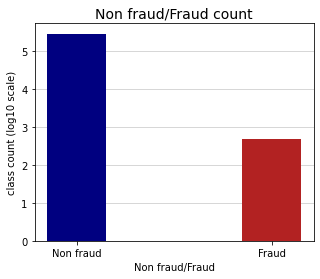

In [9]:
plt.figure(figsize=(5,4))
plt.bar(['Non fraud', 'Fraud'], np.log10(fraud['Class'].value_counts().to_numpy()), width=0.3, color=['navy', 'firebrick'], zorder=3)

plt.title('Non fraud/Fraud count', fontsize=14)
plt.ylabel('class count (log10 scale)')
plt.xlabel('Non fraud/Fraud')
plt.grid(axis='y', linewidth=0.5)
plt.show()

### Whole dataset V1 distribution

In [10]:
def fnof_plotter_distribution(df_fraud, f_name, plot_title):
    """Plot the given distribution."""
    fig, ax = plt.subplots(1, 2, figsize=(23,4))
    sns.histplot(data=df_fraud.loc[df_fraud['Class'] == 0], x=f_name, ax=ax[0], color='navy', kde=True)
    ax[0].set_title('Non frauds distribution of {}'.format(f_name))
    

    sns.histplot(data=df_fraud.loc[df_fraud['Class'] == 1], x=f_name, ax=ax[1], color='firebrick', kde=True)
    ax[1].set_title('Frauds distribution of {}'.format(f_name))

    fig.suptitle(plot_title, fontsize=14)
    plt.show()

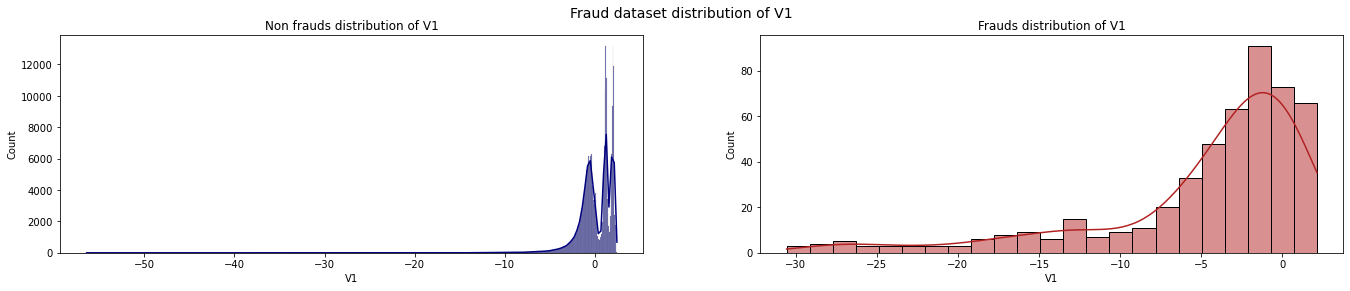

In [11]:
fnof_plotter_distribution(fraud, 'V1', 'Fraud dataset distribution of V1')

### Whole dataset Time and Amount distributions and Correlation Matrix

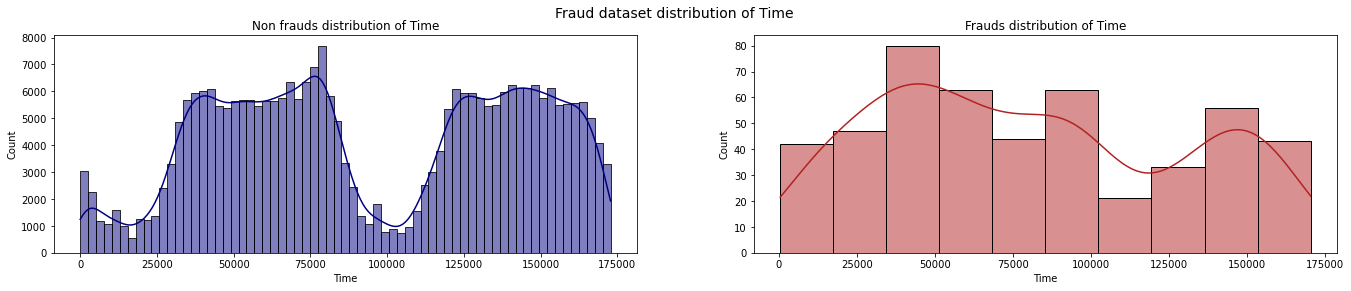

In [12]:
fnof_plotter_distribution(fraud, 'Time', 'Fraud dataset distribution of Time')

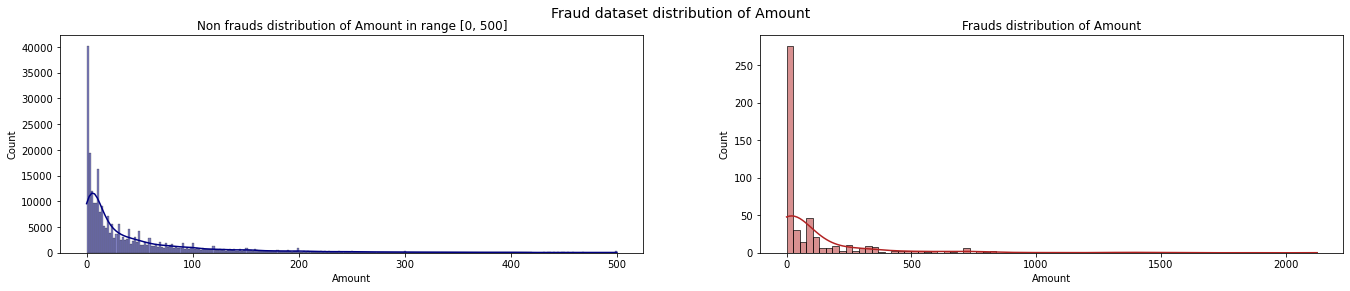

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(23,4))
sns.histplot(data=fraud.loc[(fraud['Class'] == 0) & (fraud['Amount'] <= 500)], x='Amount', ax=ax[0], color='navy', kde=True)
ax[0].set_title('Non frauds distribution of Amount in range [0, 500]')
sns.histplot(data=fraud.loc[fraud['Class'] == 1], x='Amount', ax=ax[1], color='firebrick', kde=True)
ax[1].set_title('Frauds distribution of Amount')
fig.suptitle('Fraud dataset distribution of Amount', fontsize=14)
plt.show()

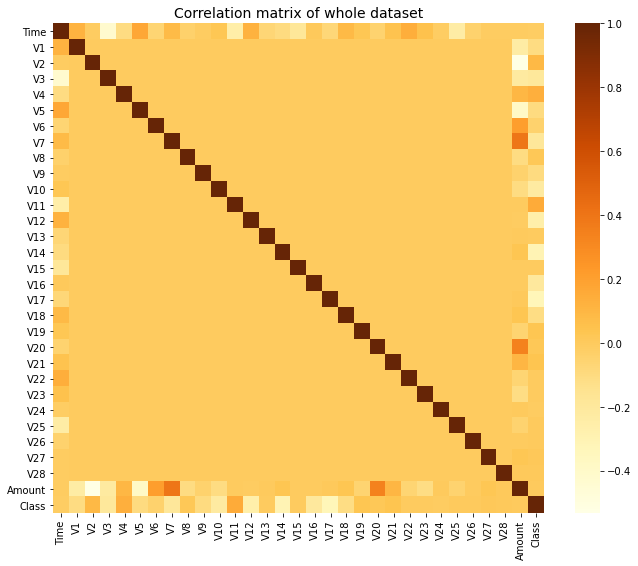

In [14]:
plt.subplots(figsize=(11,9))
corr = fraud.corr()
sns.heatmap(corr, cmap='YlOrBr', annot_kws={'size':20})
plt.title("Correlation matrix of whole dataset", fontsize=14)
plt.show()

## Outliers removal <a class="anchor" id="out-rem"></a>

The adopted outlier removal technique is IsolationForest, applied on the 'V' and 'Amount' features of the fraud dataset, on the two different Classes (fraud/non fraud) separately.
This separation is necessary because if we fit the IsolationForest on the entire dataset regardles of the Class, we empirically observe that the resulting model recognizes the minority class as an anomaly (outlier), thus eliminating almost all the samples of it.
Moreover, we fit the model on the 'V' and 'Amount' features only because by analyzing the 'Time' feature on the plotted graphs we don't recognize possible outliers in it.

In [15]:
removal_fraud = IsolationForest(max_samples='auto', random_state=RANDOM_SEED, contamination='auto', n_jobs=-1)
removal_nofraud = IsolationForest(max_samples='auto', random_state=RANDOM_SEED, contamination='auto', n_jobs=-1)

f = fraud.loc[(fraud['Class'] == 1)]
nof =  fraud.loc[(fraud['Class'] == 0)]

mask_f = removal_fraud.fit_predict(f[[col for col in f.columns if 'V' in col] + ['Amount']])
mask_nof = removal_nofraud.fit_predict(nof[[col for col in nof.columns if 'V' in col] + ['Amount']])

fraud_outliers = pd.concat([f.iloc[(mask_f == -1)], nof.iloc[(mask_nof == -1)]])
fraud_clean = pd.concat([f.iloc[~(mask_f == -1)], nof.iloc[~(mask_nof == -1)]])

#### Outliers count

In [16]:
out_count = fraud_outliers['Class'].value_counts()
out_count.index = ['Non Fraud', 'Fraud']
out_count

Non Fraud    9524
Fraud          41
Name: Class, dtype: int64

Clean dataset count

In [17]:
clean_count = fraud_clean['Class'].value_counts()
clean_count.index = ['Non Fraud', 'Fraud']
clean_count

Non Fraud    274791
Fraud           451
Name: Class, dtype: int64

### Time and Amount distributions of outliers

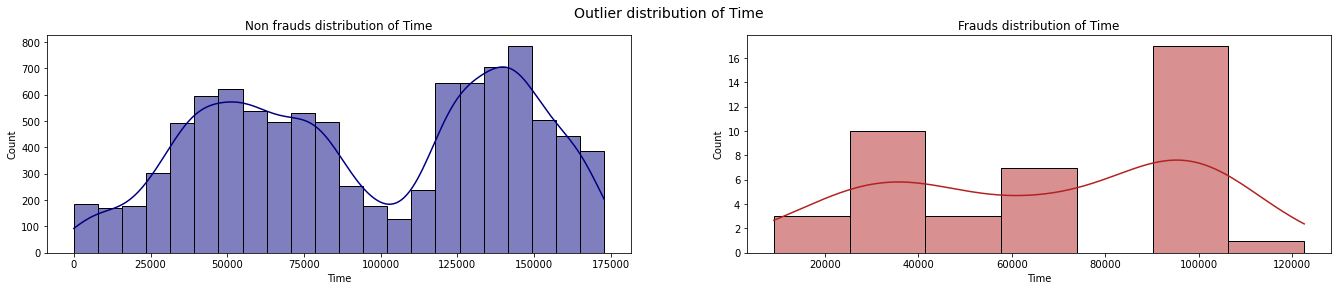

In [18]:
fnof_plotter_distribution(fraud_outliers, 'Time', 'Outlier distribution of Time')

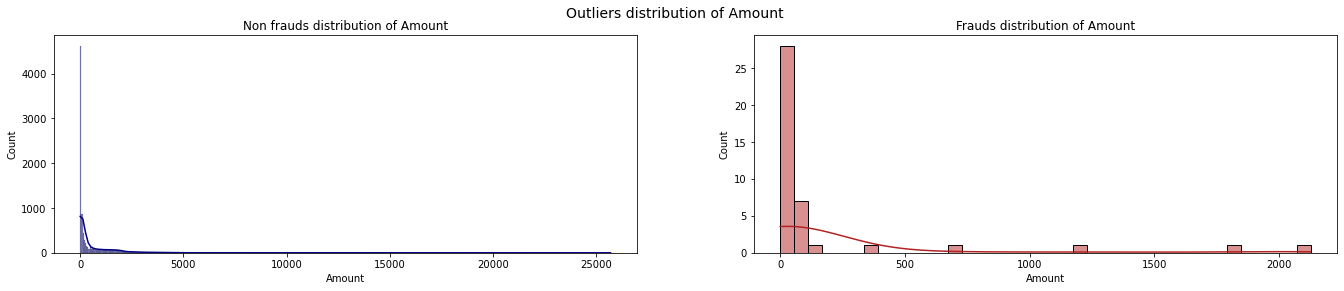

In [19]:
fnof_plotter_distribution(fraud_outliers, 'Amount', 'Outliers distribution of Amount')

### Time and Amount distributions of Clean Dataset

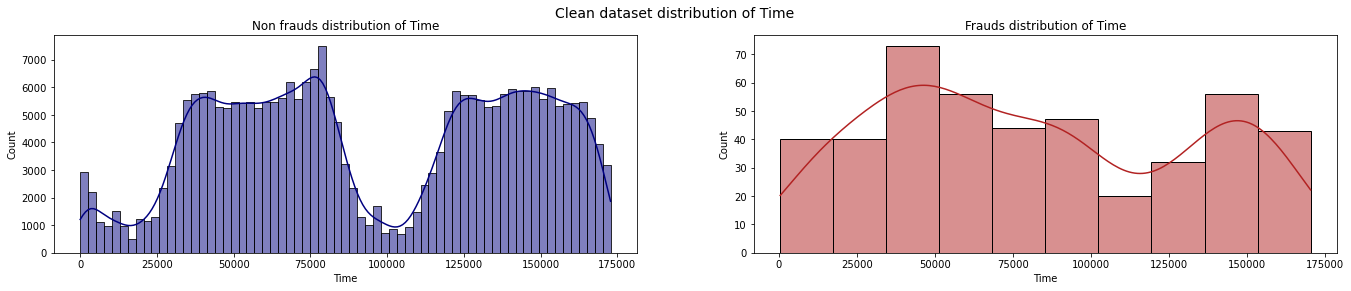

In [20]:
fnof_plotter_distribution(fraud_clean, 'Time', 'Clean dataset distribution of Time')

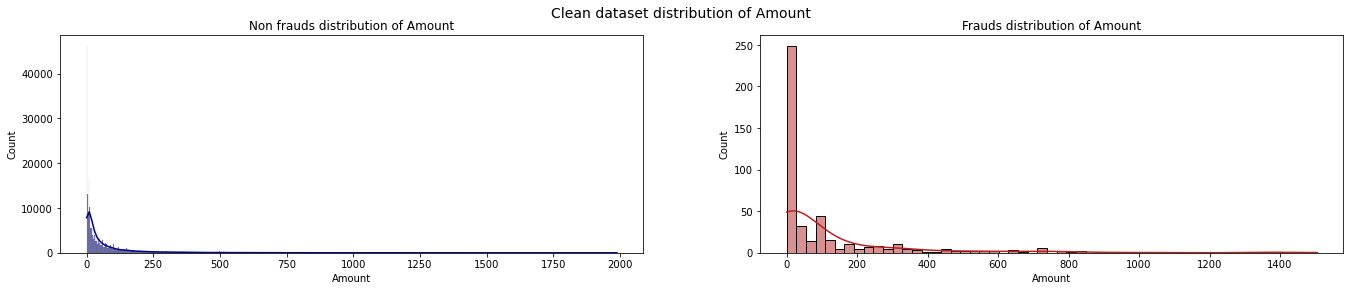

In [21]:
fnof_plotter_distribution(fraud_clean, 'Amount', 'Clean dataset distribution of Amount')

## Preprocessing of Amount and Time <a class="anchor" id="pre"></a>

These preprocessing operations are performed on the clean data only.

In [22]:
n_bins_time = 20
n_bins_amount = 20

time_dsc = KBinsDiscretizer(n_bins=n_bins_time, encode='ordinal', strategy='uniform')
amount_dsc = KBinsDiscretizer(n_bins=n_bins_amount, encode='ordinal', strategy='kmeans')


fraud_clean['amount_pre'] = amount_dsc.fit_transform(fraud_clean['Amount'].values.reshape(-1, 1))
fraud_clean['time_pre'] = time_dsc.fit_transform(fraud_clean['Time'].values.reshape(-1, 1))

## Split Train and Test sets <a class="anchor" id="split"></a>

The test set consists in 40% of the entire dataset, which allows us to  compute more meaningful test set performance metrics (compared to smaller test set sizes like 10%-20%).

In [23]:
# prepare train and test sets
x_train, x_test, y_train, y_test = train_test_split(fraud_clean[[col for col in fraud_clean.columns if ('V' in col)] + ['amount_pre', 'time_pre']].values,
                                                    fraud_clean['Class'].values,
                                                    test_size=0.4,
                                                    random_state=RANDOM_SEED,
                                                    stratify=fraud_clean['Class'].values)

## Feature selection <a class="anchor" id="feat-sel"></a>

We are deling with a classification feature selection with numerical input variables and a categorical output. Thus, feature selection is performed using ANOVA F measure via the f_classif() function.

In [24]:
def features_sel(x_train, x_test, y_train, k_features=10, verbose=True):
    """ANOVA feature selection for numeric input and categorical output."""
    fs = SelectKBest(score_func=f_classif, k=k_features)
    x_train_sel = fs.fit_transform(x_train, y_train)
    x_test_sel = fs.transform(x_test)
    supp = fs.get_support()
    if verbose:
        print('Selected support: ')
        print(pd.Index([elem for elem in fraud.columns if elem != 'Class'])[supp])
    return x_train_sel, x_test_sel, supp


def plotter_feature_sel(x_train, y_train):
    """Plot feature selection scores."""
    # Logistic Regression
    est = LogisticRegression()
    est.fit(x_train, y_train)
    lr_scores = est.coef_[0]
    
    # Random Forest
    est = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED)
    est.fit(x_train, y_train)
    rf_scores = est.feature_importances_
    
    # XGBClassifier
    est = XGBClassifier(use_label_encoder=False, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED)
    est.fit(x_train, y_train)
    xgb_scores = est.feature_importances_
    
    # ANOVA
    fs = SelectKBest(score_func=f_classif)
    x_train_sel = fs.fit(x_train, y_train)
    anova_scores = fs.scores_
    
    def single_plot(ax, support, scores, method_name):
        ax.bar(support, scores, color='navy', zorder=3)
        ax.set_ylabel('Feature importance scores ' + method_name)
        ax.grid(axis='y', linewidth=0.5, zorder=1)
        plt.setp(ax.get_xticklabels(), rotation=45)
        
    fig, ax = plt.subplots(2, 2, figsize=(23,8))
    supp = [elem for elem in fraud.columns if elem != 'Class']
    
    single_plot(ax[0][0], supp, lr_scores, 'LogisticRegression')
    single_plot(ax[0][1], supp, rf_scores, 'RandomForest')
    single_plot(ax[1][0], supp, xgb_scores, 'XGBClassifier')
    single_plot(ax[1][1], supp, anova_scores, 'ANOVA')
    
    fig.suptitle('Feature importance', fontsize=14)
    plt.show()
    

### Analysis of Feature importance

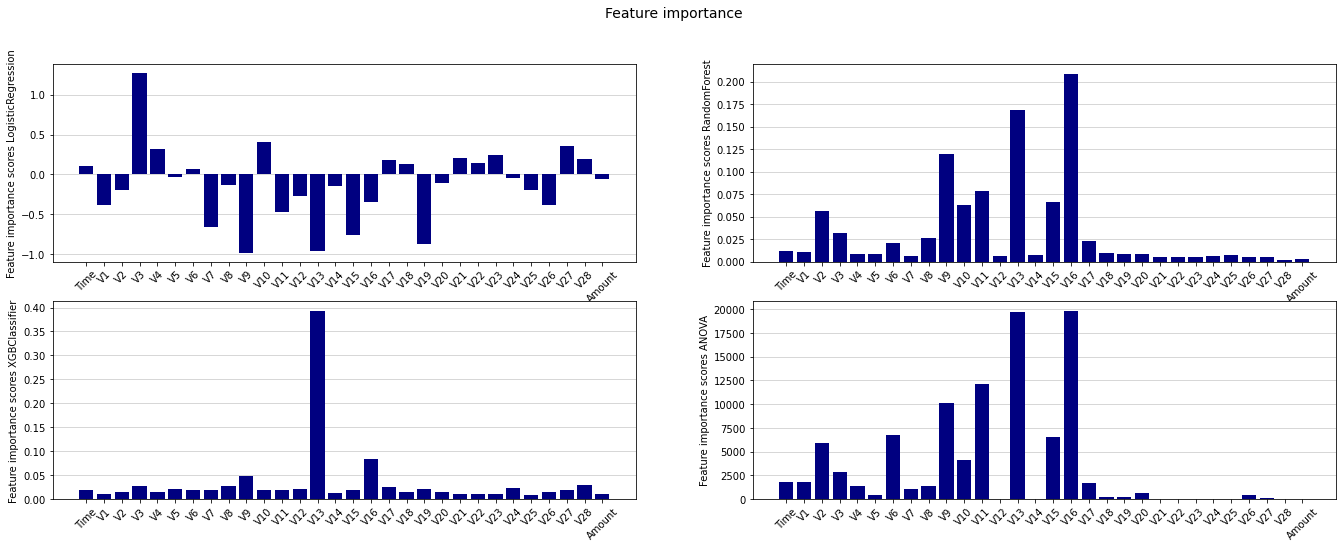

In [25]:
plotter_feature_sel(x_train, y_train)

### Feature selection based on ANOVA

A total of 20 features are selected according to the ANOVA metric. We empirically observe that increasing the number of features doesn't improve the trained models' performances, and decreasing it results in poorer performances.

In [26]:
x_train_sel, x_test_sel, supp = features_sel(x_train, x_test, y_train, k_features=20)

Selected support: 
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V13', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V26'],
      dtype='object')


# Binary Classification

In [27]:
def pretty_confusion_matrix(y_test, y_pred):
    """Return a 'pretty' confusion matrix."""
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return pd.DataFrame({'Predicted Fraud': [tp, fp], 'Predicted Not Fraud': [fn, tn]}, index=['Fraud', 'Not Fraud'])


def print_tuning_meter(stats):
    """Print tuning_meter results and  return the confusion matrix."""
    print('_____Test set statistics_____')
    print(stats['test_report'])
    print('ROC auc score: {:.3f}'.format(stats['test_roc_auc']))
    print('Confusion matrix:')
    print(stats['test_cm'])


def tuning_meter(estimator, param_grid, x_train, x_test, y_train, y_test, scoring='f1', cv=3, verbose=True):
    """Parameter grid search of the estimator, and return the test set performance metrics and the trained best model (fitted on the entire training set)."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    clf = GridSearchCV(estimator, param_grid, scoring=scoring, n_jobs=-1, cv=skf)
    start_time = time.time()
    clf.fit(x_train, y_train)
    print('GridSearchCV time: {:.1f} secs'.format(time.time()-start_time))
    y_pred = clf.predict(x_test)
    test_cm = pretty_confusion_matrix(y_test, y_pred)
    test_report = classification_report(y_test, y_pred, target_names=['Non Fraud', 'Fraud'])
    test_roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    if verbose:
        for i, (param, mean, std) in enumerate(zip(clf.cv_results_['params'], clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'])):
            print('Parameters {}: validation {} score {:.3f}+/-{:.3f}'.format(param, scoring, mean, std))
    
    
    return {'est': clf, 'test_cm': test_cm, 'test_report': test_report, 'test_roc_auc': test_roc_auc, 'test_recall': rec, 'test_f1': f1, 'test_precision': prec}


def test_meter(estimator, x_train, x_test, y_train, y_test):
    """Fit the model on the training data and compute test set performance metrics."""
    start_time = time.time()
    estimator.fit(x_train, y_train)
    print('Training time: {:.1f} secs'.format(time.time()-start_time))
    start_time = time.time()
    y_pred = estimator.predict(x_test)
    print('Inference time: {:.1f} secs'.format(time.time()-start_time))
    test_cm = pretty_confusion_matrix(y_test, y_pred)
    test_report = classification_report(y_test, y_pred, target_names=['Non Fraud', 'Fraud'])
    test_roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    return {'est': estimator, 'test_cm': test_cm, 'test_report': test_report, 'test_roc_auc': test_roc_auc, 'test_recall': rec, 'test_f1': f1, 'test_precision': prec}
    

def plotter_meter(estimator, sampling_strategy_list, x_train, y_train, n_splits=3):
    """Perform Stratified K-fold on each upsampling/downsampling 'sampling stategy' parameter, and plot validation set statistics such as recall, precision, f1 score auc roc.
    Only one upsampling/downsampling technique at a time is accepted in the given estimator.
    """
    prms = []
    for param in est.get_params().keys():
        if 'sampling_strategy' in param:
            for st in sampling_strategy_list:
                prms.append({param: st})
            break
    
    recall = list()
    recall_std = list()
    precision = list()
    precision_std = list()
    f1 = list()
    f1_std = list()
    roc_auc = list()
    roc_auc_std = list()
    
    start_time = time.time()
    for pr in prms:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
        estimator.set_params(**pr)
        recall_tmp = list()
        precision_tmp = list()
        f1_tmp = list()
        roc_auc_tmp = list()
        
        for train_index, test_index in skf.split(x_train, y_train):
            x_t, x_v = x_train[train_index], x_train[test_index]
            y_t, y_v = y_train[train_index], y_train[test_index]
            
            estimator.fit(x_t, y_t)
            y_p = estimator.predict(x_v)
          
            roc_auc_tmp.append(roc_auc_score(y_v, y_p))
            f1_tmp.append(f1_score(y_v, y_p))
            precision_tmp.append(precision_score(y_v, y_p))
            recall_tmp.append(recall_score(y_v, y_p))
        
        recall.append(np.mean(np.array(recall_tmp)))
        recall_std.append(np.std(np.array(recall_tmp)))
        precision.append(np.mean(np.array(precision_tmp)))
        precision_std.append(np.std(np.array(precision_tmp)))
        f1.append(np.mean(np.array(f1_tmp)))
        f1_std.append(np.std(np.array(f1_tmp)))
        roc_auc.append(np.mean(np.array(roc_auc_tmp)))
        roc_auc_std.append(np.std(np.array(roc_auc_tmp)))
        
    print('Cross validation time: {:.1f} secs'.format(time.time()-start_time))
    
    fig, ax = plt.subplots(2, 2, figsize=(23,8))
    
    def single_plot(ax, metric, metric_std, metric_name):
        ax.plot(sampling_strategy_list, metric)
        ax.fill_between(sampling_strategy_list, np.array(metric) - np.array(metric_std), np.array(metric) + np.array(metric_std), alpha=.2)
        ax.set_xlabel('sampling_strategy')
        ax.set_ylabel('val ' + metric_name)
        ax.set_xticks(sampling_strategy_list)
        ax.set_yticks(np.linspace(0, 1, 11))
        ax.grid(linewidth=0.5)
        
    single_plot(ax[0][0], recall, recall_std, 'recall')
    single_plot(ax[0][1], precision, precision_std, 'precision')
    single_plot(ax[1][0], f1, f1_std, 'f1-score')
    single_plot(ax[1][1], roc_auc, roc_auc_std, 'ROC AUC')
    
    fig.suptitle('Validation Metrics', fontsize=14)
    plt.show()


## 1. Plain Binary classification <a class="anchor" id="plain-c"></a>

In this section we fit different binary classification models on the clean Fraud Dataset. 
The reported metrics are all computed on the Test set and include precision, recall, f1-score, ROC AUC, accuracy and the resulting confusion  matrices.

We analyze the models' performances on both the complete Clean Fraud dataset and the feature-selected version of it.

The chosen hyperparameters have been previously selected with a grid search with stratified k-fold cross validation optimized on the f1-score (with function tuning_meter).

In [28]:
GRID_SEARCH_MODE = False

### 1.1 XGBClassifier

### Selected features fraud dataset

In [29]:
if GRID_SEARCH_MODE:
    param_grid = {'n_estimators': [100, 200, 400], 'max_depth': [10, 20], 'learning_rate': [0.05, 0.1, 0.3]}
    print_tuning_meter(tuning_meter(XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=RANDOM_SEED), param_grid, x_train_sel, x_test_sel, y_train, y_test, scoring='f1', cv=3))
else:
    est = XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED)
    print_tuning_meter(test_meter(est, x_train_sel, x_test_sel, y_train, y_test))

Training time: 60.3 secs
Inference time: 0.3 secs
_____Test set statistics_____
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    109917
       Fraud       0.99      0.83      0.91       180

    accuracy                           1.00    110097
   macro avg       1.00      0.92      0.95    110097
weighted avg       1.00      1.00      1.00    110097

ROC auc score: 0.917
Confusion matrix:
           Predicted Fraud  Predicted Not Fraud
Fraud                  150                   30
Not Fraud                1               109916


### Complete fraud dataset

In [30]:
if GRID_SEARCH_MODE:
    param_grid = {'n_estimators': [100, 200, 400], 'max_depth': [10, 20], 'learning_rate': [0.05, 0.1, 0.3]}
    print_tuning_meter(tuning_meter(XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=RANDOM_SEED), param_grid, x_train, x_test, y_train, y_test, scoring='f1', cv=3))
else:
    est = XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED)
    print_tuning_meter(test_meter(est, x_train, x_test, y_train, y_test))

Training time: 76.1 secs
Inference time: 0.2 secs
_____Test set statistics_____
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    109917
       Fraud       0.99      0.84      0.91       180

    accuracy                           1.00    110097
   macro avg       1.00      0.92      0.95    110097
weighted avg       1.00      1.00      1.00    110097

ROC auc score: 0.919
Confusion matrix:
           Predicted Fraud  Predicted Not Fraud
Fraud                  151                   29
Not Fraud                1               109916


### 1.2 Random Forest

### Selected features fraud dataset

In [31]:
if GRID_SEARCH_MODE:
    param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}
    print_tuning_meter(tuning_meter(RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED), param_grid, x_train_sel, x_test_sel, y_train, y_test, scoring='f1', cv=3))
else:
    est = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED)
    print_tuning_meter(test_meter(est, x_train_sel, x_test_sel, y_train, y_test))

Training time: 15.7 secs
Inference time: 0.2 secs
_____Test set statistics_____
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    109917
       Fraud       0.99      0.84      0.91       180

    accuracy                           1.00    110097
   macro avg       0.99      0.92      0.95    110097
weighted avg       1.00      1.00      1.00    110097

ROC auc score: 0.919
Confusion matrix:
           Predicted Fraud  Predicted Not Fraud
Fraud                  151                   29
Not Fraud                2               109915


### Complete fraud dataset

In [32]:
if GRID_SEARCH_MODE:
    param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}
    print_tuning_meter(tuning_meter(RandomForestClassifier(n_jobs=-1), param_grid, x_train, x_test, y_train, y_test, scoring='f1', cv=3))
else:
    est = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED)
    print_tuning_meter(test_meter(est, x_train, x_test, y_train, y_test))

Training time: 65.7 secs
Inference time: 0.4 secs
_____Test set statistics_____
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    109917
       Fraud       0.98      0.84      0.90       180

    accuracy                           1.00    110097
   macro avg       0.99      0.92      0.95    110097
weighted avg       1.00      1.00      1.00    110097

ROC auc score: 0.919
Confusion matrix:
           Predicted Fraud  Predicted Not Fraud
Fraud                  151                   29
Not Fraud                3               109914


### 1.3 KNN
### Selected features fraud dataset

In [33]:
if GRID_SEARCH_MODE:
    param_grid = {'n_neighbors': [3, 5], 'p': [1, 2, 3]}
    print_tuning_meter(tuning_meter(KNeighborsClassifier(n_jobs=-1), param_grid, x_train_sel, x_test_sel, y_train, y_test, scoring='f1', cv=3))
else:
    est = KNeighborsClassifier(n_neighbors=3, p=1, n_jobs=-1)
    print_tuning_meter(test_meter(est, x_train_sel, x_test_sel, y_train, y_test))

Training time: 0.8 secs
Inference time: 117.6 secs
_____Test set statistics_____
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    109917
       Fraud       1.00      0.82      0.90       180

    accuracy                           1.00    110097
   macro avg       1.00      0.91      0.95    110097
weighted avg       1.00      1.00      1.00    110097

ROC auc score: 0.908
Confusion matrix:
           Predicted Fraud  Predicted Not Fraud
Fraud                  147                   33
Not Fraud                0               109917


### 1.4 Logistic Regression

### Selected features fraud dataset

In [34]:
if GRID_SEARCH_MODE:
    param_grid = {'C': [0.1, 1, 10]}
    print_tuning_meter(tuning_meter(LogisticRegression(n_jobs=-1), param_grid, x_train_sel, x_test_sel, y_train, y_test, scoring='f1', cv=3))
else:
    est = LogisticRegression(C=0.1, n_jobs=-1)
    print_tuning_meter(test_meter(est, x_train_sel, x_test_sel, y_train, y_test))

Training time: 3.0 secs
Inference time: 0.0 secs
_____Test set statistics_____
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    109917
       Fraud       0.99      0.82      0.90       180

    accuracy                           1.00    110097
   macro avg       1.00      0.91      0.95    110097
weighted avg       1.00      1.00      1.00    110097

ROC auc score: 0.911
Confusion matrix:
           Predicted Fraud  Predicted Not Fraud
Fraud                  148                   32
Not Fraud                1               109916


### Complete fraud dataset

In [35]:
if GRID_SEARCH_MODE:
    param_grid = {'C': [0.1, 1, 10]}
    print_tuning_meter(tuning_meter(LogisticRegression(C=0.1, n_jobs=-1), param_grid, x_train, x_test, y_train, y_test, scoring='f1', cv=3))
else:
    est = LogisticRegression(C=0.1, n_jobs=-1)
    print_tuning_meter(test_meter(est, x_train, x_test, y_train, y_test))

Training time: 8.8 secs
Inference time: 0.0 secs
_____Test set statistics_____
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00    109917
       Fraud       0.99      0.82      0.90       180

    accuracy                           1.00    110097
   macro avg       1.00      0.91      0.95    110097
weighted avg       1.00      1.00      1.00    110097

ROC auc score: 0.911
Confusion matrix:
           Predicted Fraud  Predicted Not Fraud
Fraud                  148                   32
Not Fraud                1               109916


## 2. Undersampling Technique <a class="anchor" id="und-c"></a>

In this section we analyze the behaviour of some undersampling algorithms, such as Random Undersampling, NearMiss and finally Condensed Nearest Neighbour. We train the resulting models (except for Condensed Nearest Neighbour, which doesn't have this parameter) with different 'undersampling strenghts' (controlled with the sampling_strategy parameter) to determine the influence of such hyperparameter on the resulting models' performances. In particular, we will report different validation metrics, found by cross validation on the Training set, such as precision, recall, f1-score, and ROC AUC.

The features selected version of the dataset is used (easing the amount of computation needed).

The classification model of choice is the XGB classifier which is proven to have the best Test set performances on the former Plain Classification section. The model's hyperparameters also come from the previous section.

imbalanced-learn package documentation: https://imbalanced-learn.org/stable/api.html#module-imblearn.under_sampling

### 2.1 Random Undersampling + XGBClassifier

Cross validation time: 21.2 secs


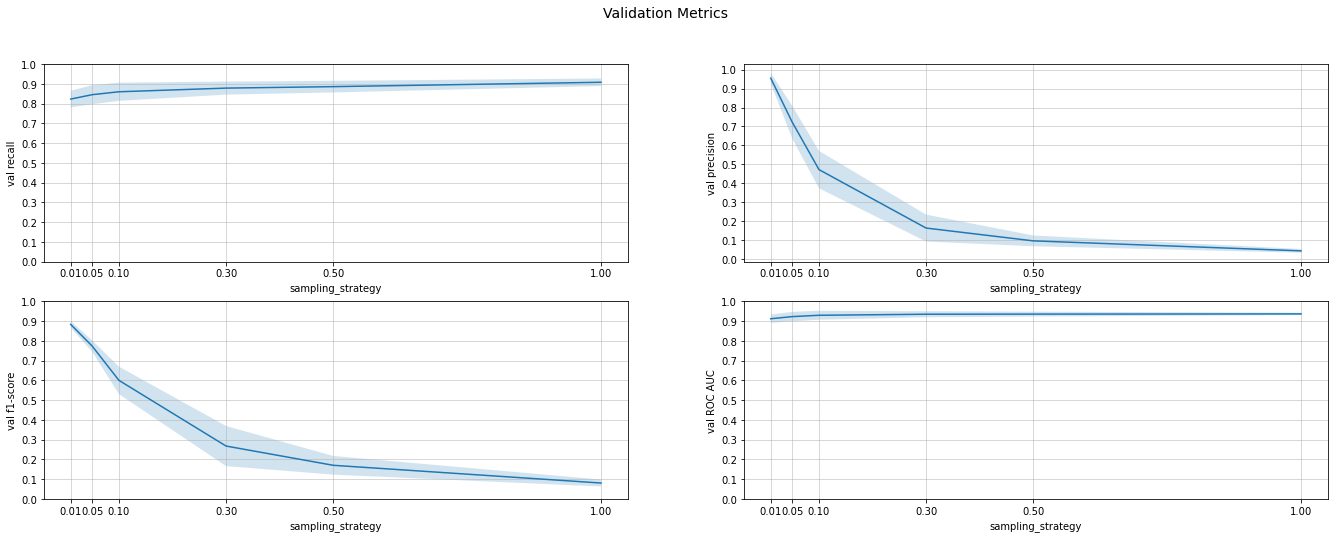

In [36]:
est = ImbPipeline([('under', RandomUnderSampler(random_state=RANDOM_SEED)),
                   ('xgb', XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED))])
plotter_meter(est, [0.01, 0.05, 0.1, 0.3, 0.5, 1], x_train_sel, y_train)

### 2.2 NearMiss + XGBClassifier

Cross validation time: 30.5 secs


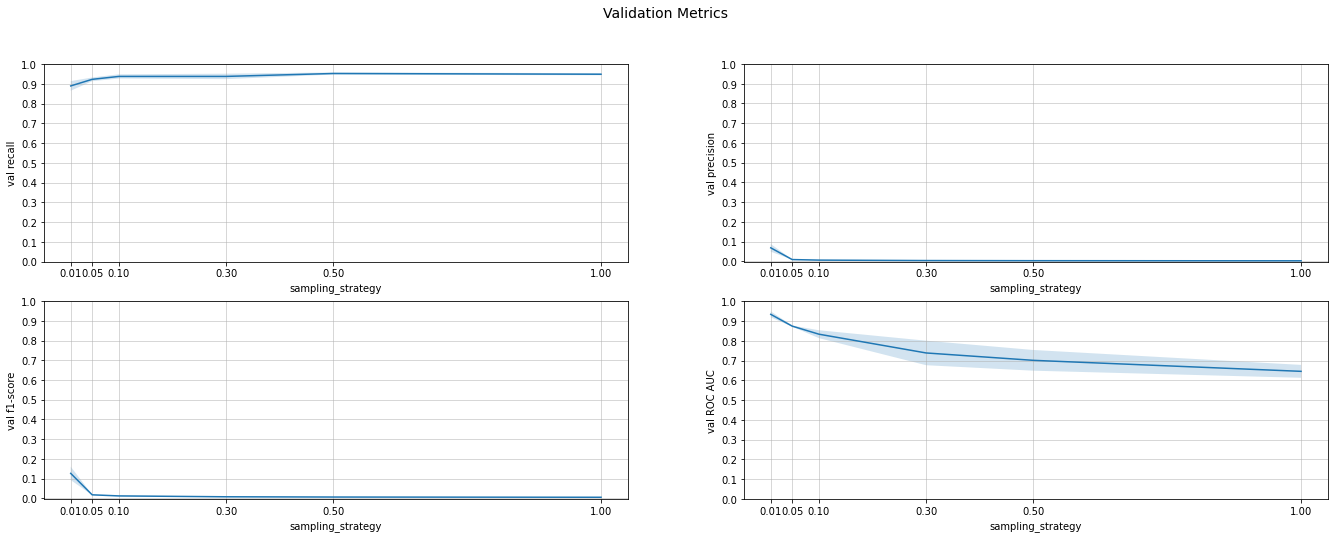

In [37]:
est = ImbPipeline([('under', NearMiss(n_jobs=-1)),
                   ('xgb', XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED))])
plotter_meter(est, [0.01, 0.05, 0.1, 0.3, 0.5, 1], x_train_sel, y_train)

### 2.3 CondensedNearestNeighbour + XGBClassifier

In [38]:
"""
est = ImbPipeline([('under', CondensedNearestNeighbour(random_state=RANDOM_SEED, n_jobs=-1)),
                   ('xgb', XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED))])
print_tuning_meter(test_meter(est, x_train_sel, x_test_sel, y_train, y_test))
"""

"\nest = ImbPipeline([('under', CondensedNearestNeighbour(random_state=RANDOM_SEED, n_jobs=-1)),\n                   ('xgb', XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED))])\nprint_tuning_meter(test_meter(est, x_train_sel, x_test_sel, y_train, y_test))\n"

Results for CondensedNearestNeighbour with XGBClasifier:

Training time: 3796.5 secs

Inference time: 0.2 secs

_____Test set statistics_____

precision: 0.77 

recall: 0.85 

f1-score: 0.81

ROC auc score:	0.9247862023162933

**Note:** The Test set results for this model are reported in this way because they require too much time to be computed. 

## TSNE: visualizing undersampled Training datasets

Visualization of undersampled Train dataset. The applied undersampling techniques are RandomUnderSampler and NearMiss.
TSNE is applied after the former dataset has been undersampled to better understand the effect of the undersapling techniques.
Both undersampling techniques are chosen with a sampling_strategy of 0.2 .

The features selected version of the dataset is used (easing the amount of computation needed).

In [39]:
def sampling_tsne_plot(undersampling_techniques, x_train, y_train):
    """Plotting under/over sampled dataset with TSNE."""
    fig, ax = plt.subplots(1, len(undersampling_techniques), figsize=(8*len(undersampling_techniques)+1, 8))
    
    for i, und_t in enumerate(undersampling_techniques):
        x_train_tsne, y_train_tsne = und_t[1].fit_resample(x_train, y_train)
        tsne = TSNE(n_components=2, n_jobs=-1)
        x_train_tsne = tsne.fit_transform(x_train_tsne)
        df_tsne = pd.DataFrame(x_train_tsne, columns=['tsne_dim1', 'tsne_dim2'])
        df_tsne['Class'] = pd.DataFrame(y_train_tsne)
        
        if len(undersampling_techniques)>1:
            sns.scatterplot(data=df_tsne, x='tsne_dim1', y='tsne_dim2', hue='Class', ax=ax[i], palette=['navy', 'firebrick'])
            ax[i].grid(linewidth=0.5)
            ax[i].set_title(und_t[0])
        else:
            sns.scatterplot(data=df_tsne, x='tsne_dim1', y='tsne_dim2', hue='Class', palette=['navy', 'firebrick'])
            plt.grid(linewidth=0.5)
            plt.title(und_t[0])
    
    fig.suptitle('TSNE plot', fontsize=14)
    plt.show()

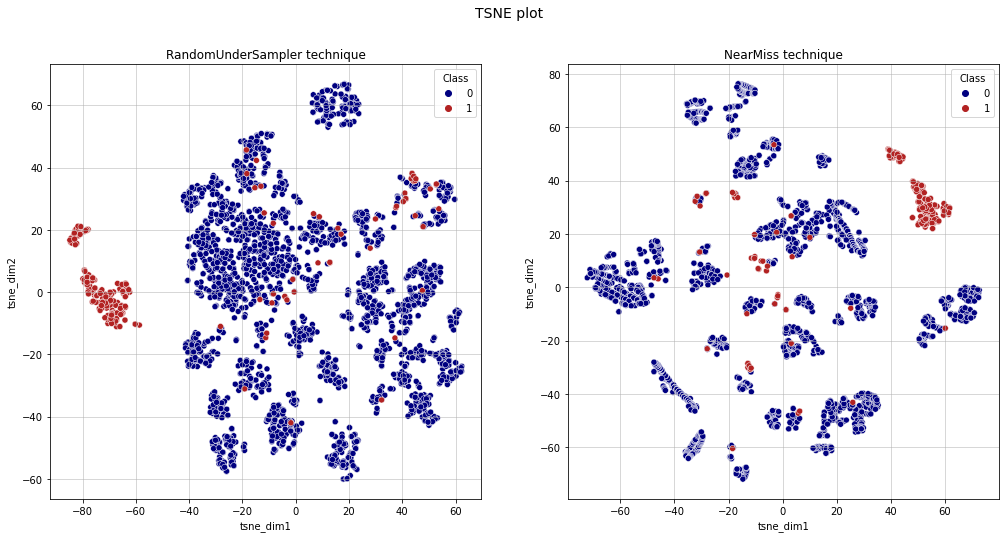

In [40]:
techniques = [('RandomUnderSampler technique', RandomUnderSampler(sampling_strategy=0.1, random_state=RANDOM_SEED)),
              ('NearMiss technique', NearMiss(sampling_strategy=0.1, n_jobs=-1))]
sampling_tsne_plot(techniques, x_train_sel, y_train)

## 3. Oversampling Technique <a class="anchor" id="ov-c"></a>

In this section we analyze the behaviour of some oversampling techniques, such as SMOTE, ADASYN, and a variant of SMOTE called BorderlineSMOTE.
We train the resulting models with different 'oversampling strenghts' (controlled with the sampling_strategy parameter) to determine the influence of such hyperparameter on the resulting models' performances.
In particular, we will report different validation metrics, found by cross validation on the Training set, such as precision, recall, f1-score, and ROC AUC.

The features selected version of the dataset is used (easing the amount of computation needed).

The classification model of choice is the XGB classifier which is proven to have the best Test set performances on the former Plain Classification section. The model's hyperparameters also come from the previous section.

+ imbalanced-learn package documentation: https://imbalanced-learn.org/stable/api.html#module-imblearn.under_sampling
+ oversampling, a practical guide: https://imbalanced-learn.org/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn

### 3.1 SMOTE + XGBClassifier

Cross validation time: 1143.3 secs


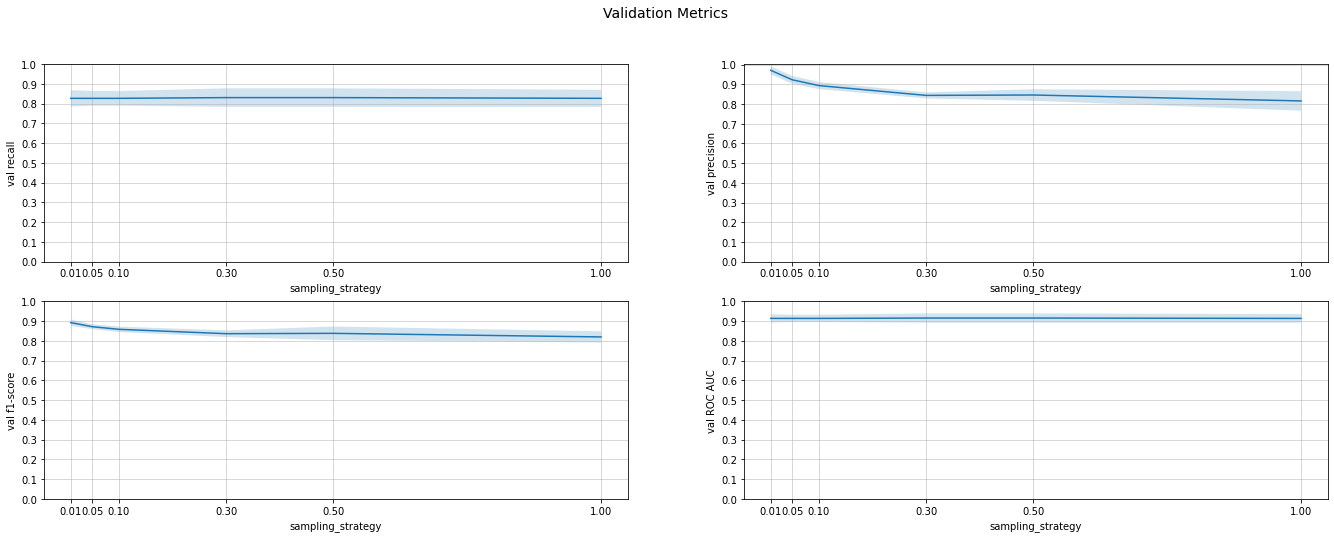

In [41]:
est = ImbPipeline([('under', SMOTE(random_state=RANDOM_SEED, n_jobs=-1)),
                   ('xgb', XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED))])
plotter_meter(est, [0.01, 0.05, 0.1, 0.3, 0.5, 1], x_train_sel, y_train)

### 3.2 BorderlineSMOTE + XGBClassifier

Cross validation time: 884.0 secs


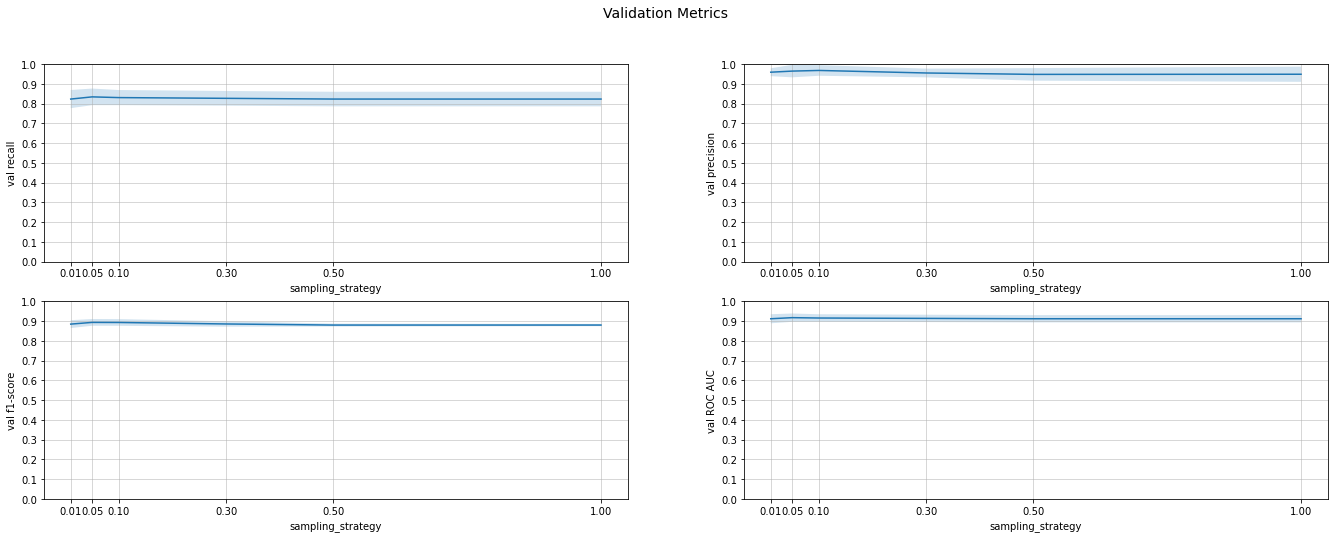

In [42]:
est = ImbPipeline([('under', BorderlineSMOTE(random_state=RANDOM_SEED, n_jobs=-1)),
                   ('xgb', XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED))])
plotter_meter(est, [0.01, 0.05, 0.1, 0.3, 0.5, 1], x_train_sel, y_train)

### 3.3 ADASYN + XGBClassifier

Cross validation time: 1357.3 secs


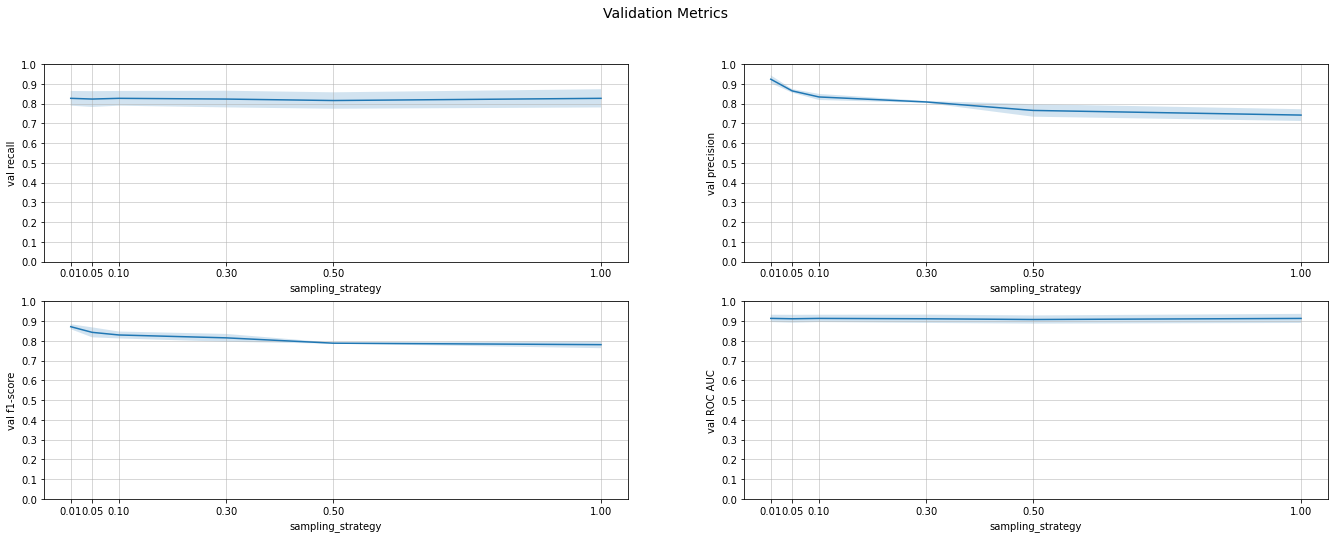

In [43]:
est = ImbPipeline([('under', ADASYN(random_state=RANDOM_SEED, n_jobs=-1)),
                   ('xgb', XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED))])
plotter_meter(est, [0.01, 0.05, 0.1, 0.3, 0.5, 1], x_train_sel, y_train)

## TSNE: visualizing oversampled Training datasets

Visualization of oversampled Train dataset. The applied undersampling techniques are SMOTE and BorderlineSMOTE.
TSNE is applied after the former dataset has been undersampled to better understand the effect of the undersapling techniques.
Both undersampling techniques are chosen with a sampling_strategy of 0.1 .

The features selected version of the dataset is used (easing the amount of computation needed).

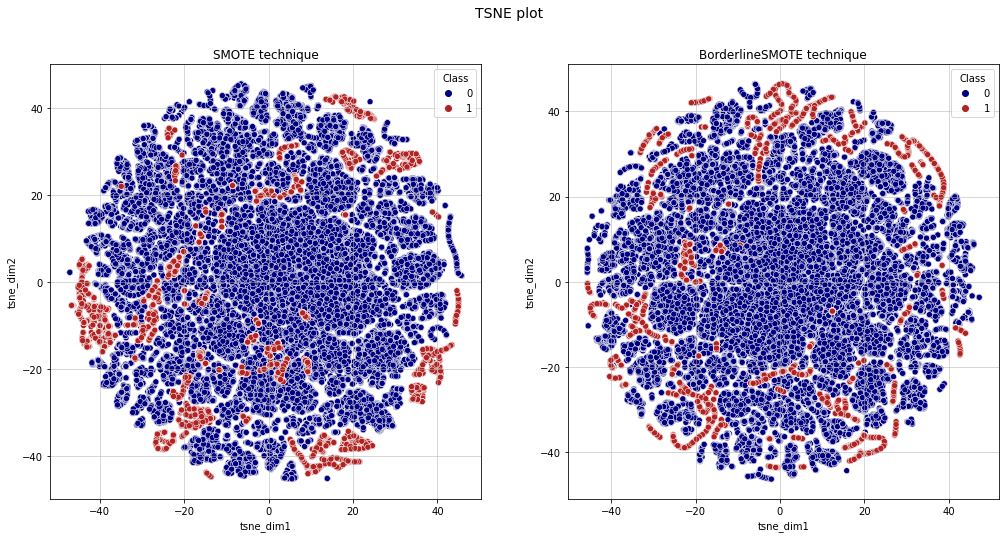

In [44]:
techniques = [('SMOTE technique', SMOTE(sampling_strategy=0.1, random_state=RANDOM_SEED, n_jobs=-1)),
              ('BorderlineSMOTE technique', BorderlineSMOTE(sampling_strategy=0.1, random_state=RANDOM_SEED, n_jobs=-1))]
sampling_tsne_plot(techniques, x_train_sel, y_train)

## 4. Combined Under/Over sampling Techniques <a class="anchor" id="mix-c"></a>

In this last section we analyze the behaviour of a combination of over/under sampling technique called SMOTEENN.
We train the resulting models with different 'oversampling strenghts' (controlled with the sampling_strategy parameter) to determine the influence of such hyperparameter on the resulting models' performances.
In particular, we will report different validation metrics, found by cross validation on the Training set, such as precision, recall, f1-score, and ROC AUC.

The features selected version of the dataset is used (easing the amount of computation needed).

The classification model of choice is the XGB classifier which is proven to have the best Test set performances on the former Plain Classification section. The model's hyperparameters also come from the previous section.

+ imbalanced-learn package documentation: https://imbalanced-learn.org/stable/api.html#module-imblearn.under_sampling

### 4.1 SMOTEENN + XGBClassifier

Cross validation time: 1654.6 secs


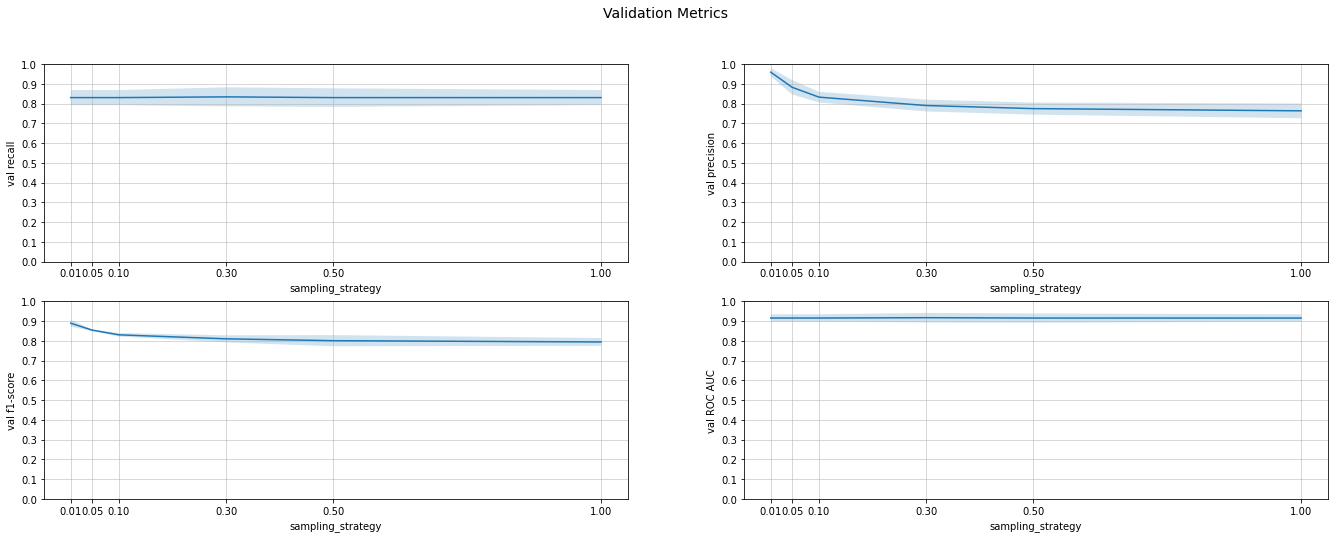

In [45]:
est = ImbPipeline([('mix', SMOTEENN(random_state=RANDOM_SEED, n_jobs=-1)),
                   ('xgb', XGBClassifier(use_label_encoder=False, n_estimators=400, learning_rate=0.3, max_depth=20, n_jobs=-1, eval_metric='logloss', random_state=RANDOM_SEED))])
plotter_meter(est, [0.01, 0.05, 0.1, 0.3, 0.5, 1], x_train_sel, y_train)

## TSNE: visualizing SMOTEENN Training dataset

Visualization of SMOTEENN Train dataset. TSNE is applied after the former dataset has been undersampled to better understand the effect of this techniques. sampling_strategy is equal to 0.1 .

The features selected version of the dataset is used (easing the amount of computation needed).

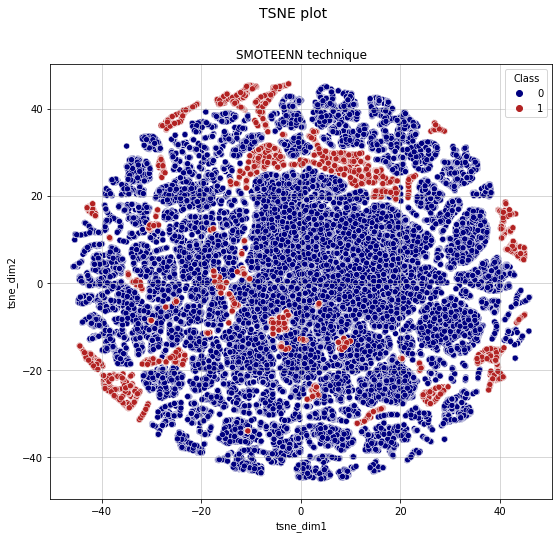

In [46]:
techniques = [('SMOTEENN technique', SMOTEENN(sampling_strategy=0.1, random_state=RANDOM_SEED, n_jobs=-1))]
sampling_tsne_plot(techniques, x_train_sel, y_train)